In [1]:
import pickle, os
import numpy as np
import scvelo as scv
import scanpy
import scipy
import torch

from veloproj import *

scv.settings.verbosity = 1


In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr', '1e-6', 
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--model-name', 'humanbonemarrow_model.cpt',
                               '--exp-name', 'CohAE_humanbonemarrow',
                               '--device', 'cuda:2',
                               '--nb_g_src', 'X',
                               '--ld_nb_g_src', 'X',
                               '--gumbsoft_tau', '1',
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'true',
                               '--use_offset_pred', 'true',
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_tsne',
                               '--vis_type_col', 'clusters',
                               '--scv_n_jobs', '10',
                              ])
args                              

Namespace(adata=None, aux_weight=1.0, conv_thred=1e-06, data_dir=None, device='cuda:2', exp_name='CohAE_humanbonemarrow', fit_offset_pred=True, fit_offset_train=False, g_rep_dim=100, gnn_layer='GAT', gumbsoft_tau=1.0, h_dim=256, k_dim=100, ld_adata='projection.h5', ld_nb_g_src='X', log_interval=100, lr=1e-06, lr_decay=0.9, mask_cluster_list=None, model_name='humanbonemarrow_model.cpt', n_conn_nb=30, n_epochs=20000, n_nb_newadata=30, n_raw_gene=2000, nb_g_src='X', output='./', refit=True, scv_n_jobs=10, seed=42, sl1_beta=1.0, use_norm=False, use_offset_pred=True, use_x=False, v_rg_wt=0.0, vis_key='X_tsne', vis_type_col='clusters', weight_decay=0.0, z_dim=100)

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("Ery_1", "Ery_2"), ("HSC_1", "HSC_2"), ('Mono_1', 'Mono_2')]
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

Abundance of ['spliced', 'unspliced']: [0.52 0.48]


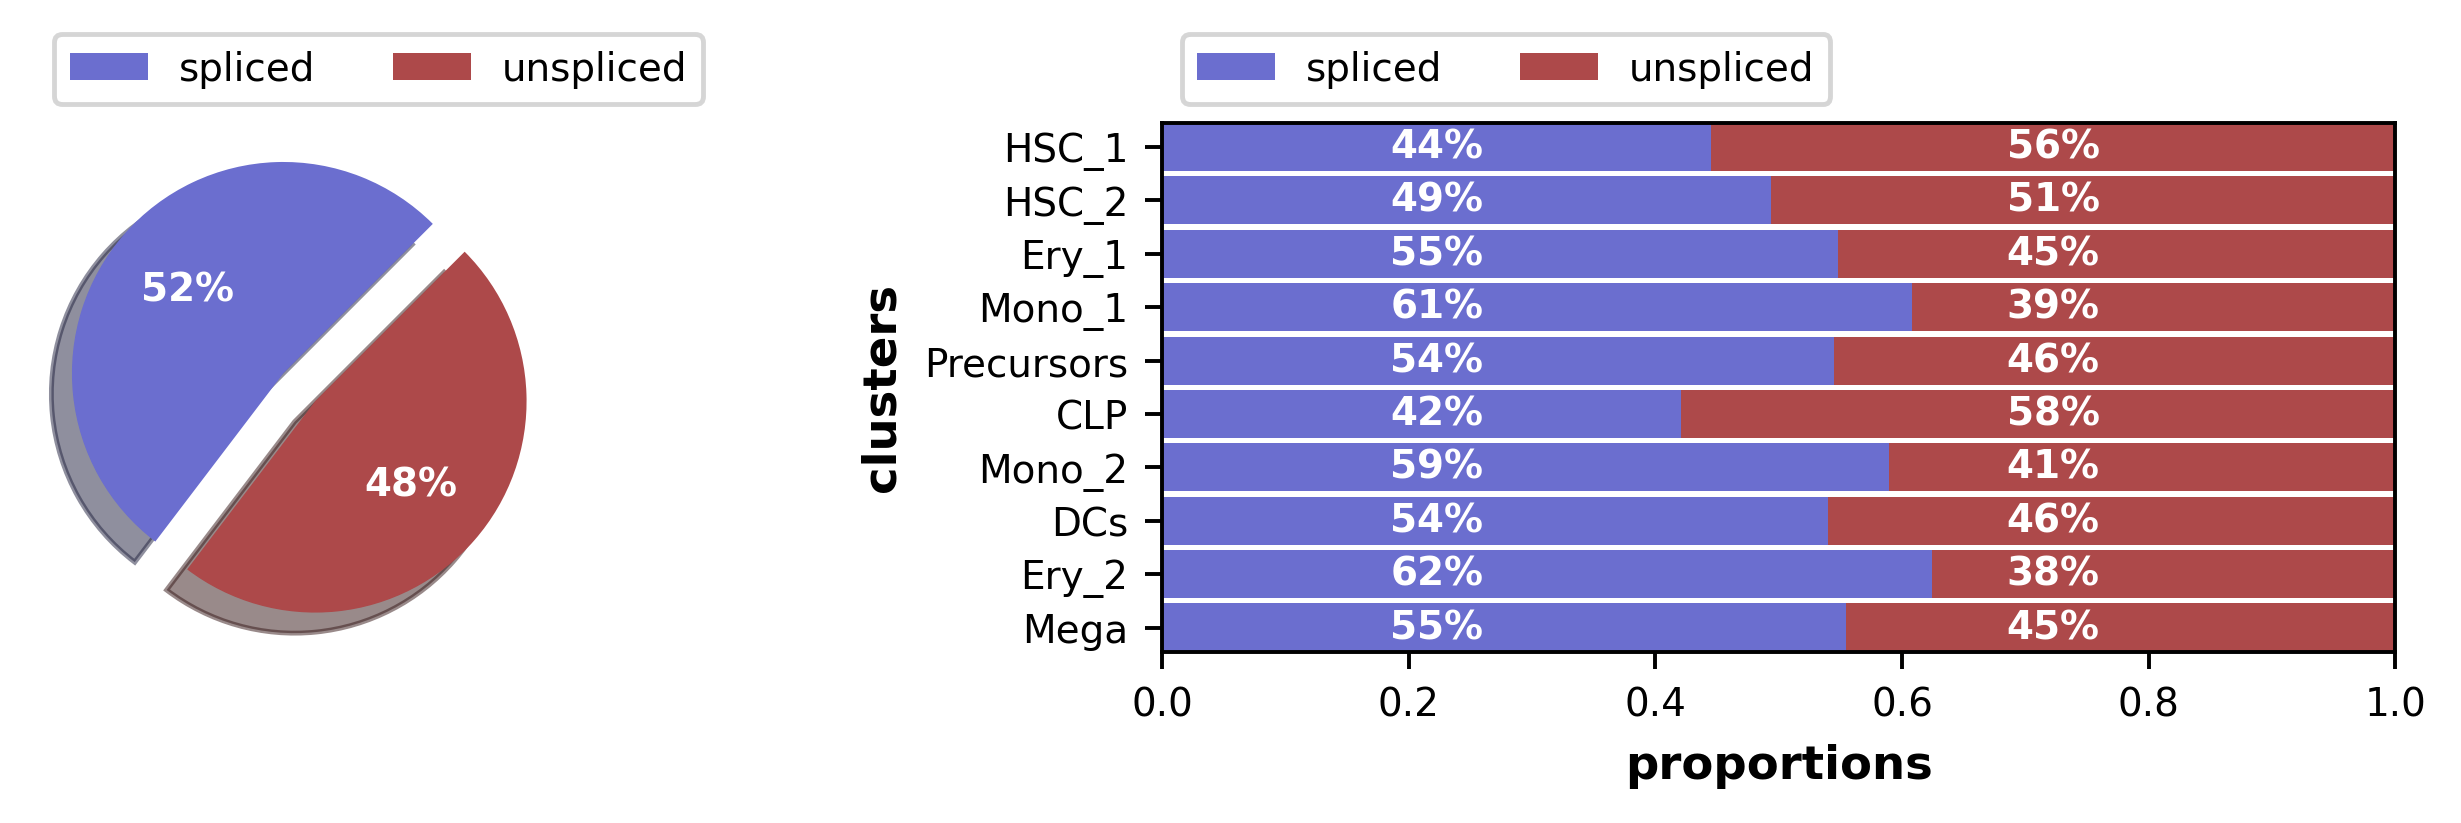

AnnData object with n_obs × n_vars = 5780 × 2000
    obs: 'clusters', 'palantir_pseudotime', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'clusters_colors', 'pca', 'neighbors'
    obsm: 'X_tsne', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


In [6]:
adata = scv.datasets.bonemarrow()
scv.pp.remove_duplicate_cells(adata)
scv.utils.show_proportions(adata)
scv.pl.proportions(adata, dpi=350)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata)
print(adata)

or disable the progress bar using `show_progress_bar=False`.
saving figure to file ./figures/scvelo_humanbonemarrao_stc.png


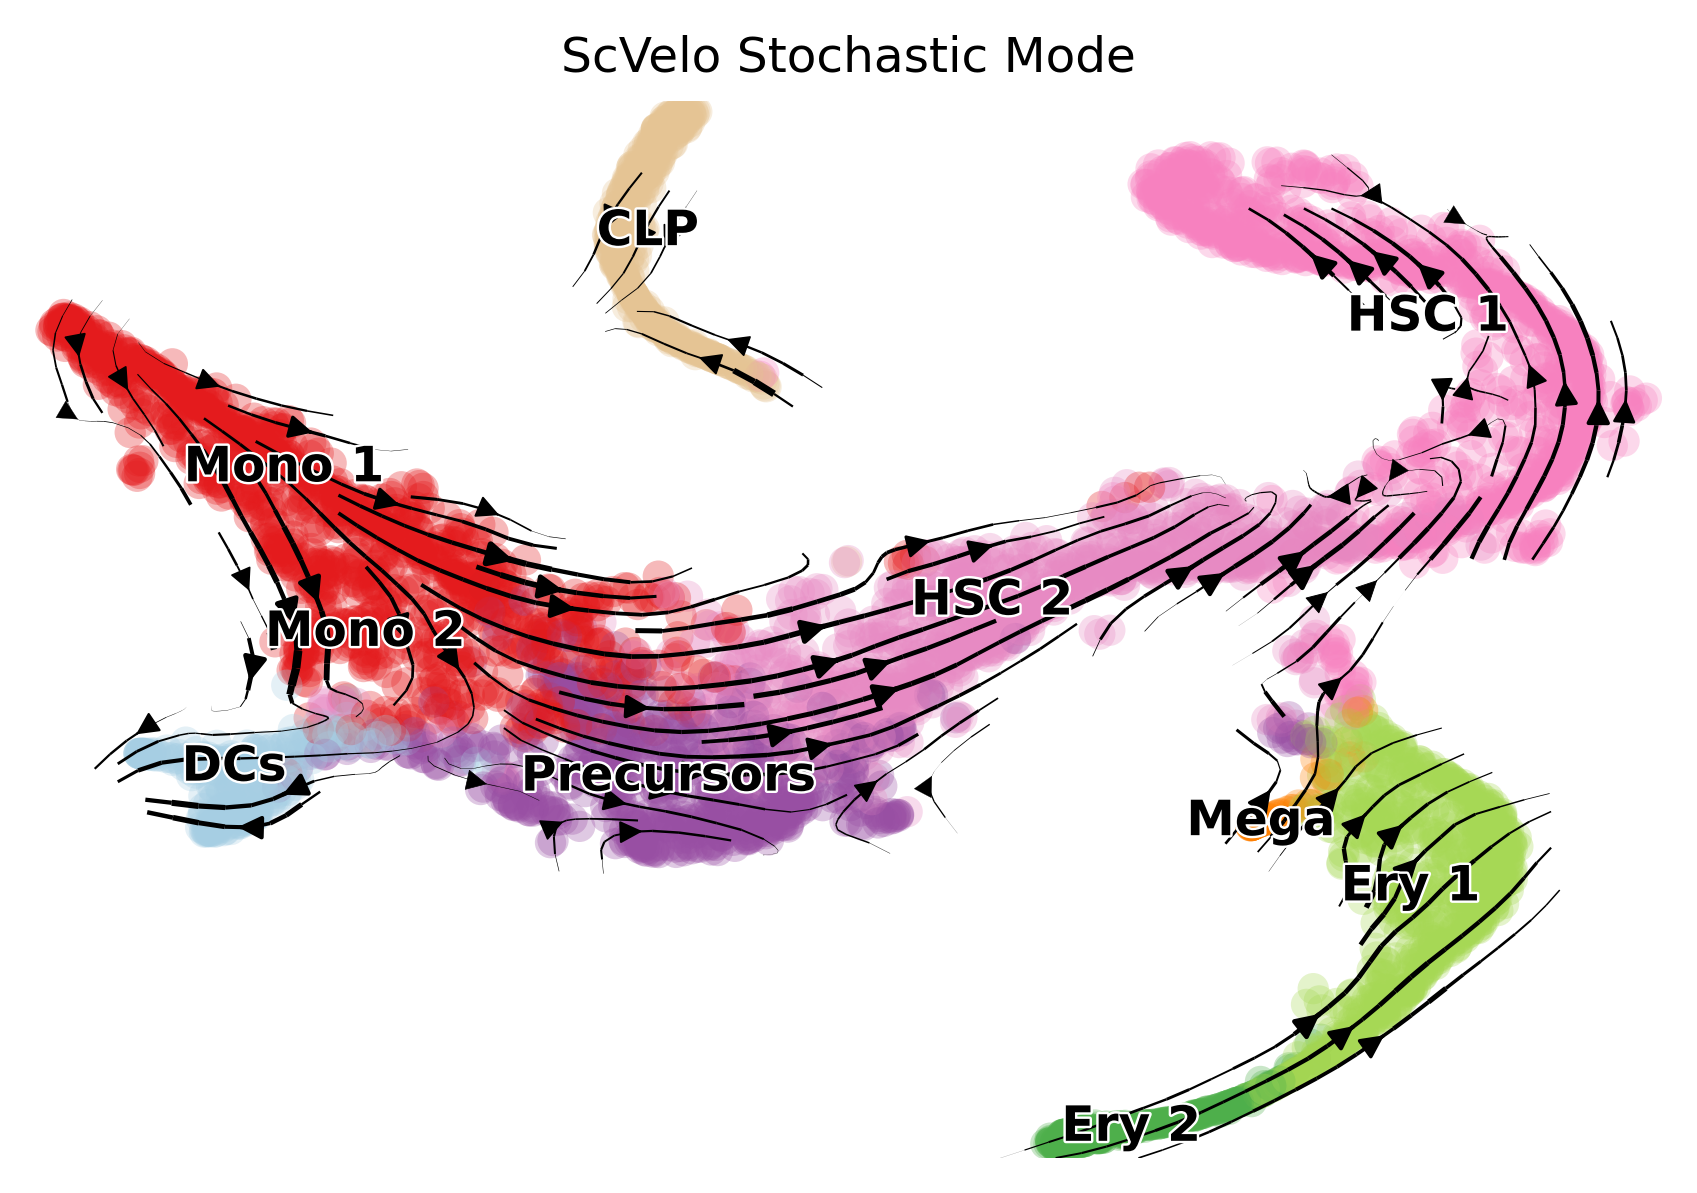

# Cross-Boundary Transition Score (A->B)
{('Ery_1', 'Ery_2'): 0.036592856, ('HSC_1', 'HSC_2'): 0.07029553, ('Mono_1', 'Mono_2'): 0.113606006}
Total Mean: 0.07349812984466553
# Cross-Boundary Velocity Coherence (A->B)
{('Ery_1', 'Ery_2'): 0.9677103, ('HSC_1', 'HSC_2'): 0.83400494, ('Mono_1', 'Mono_2'): 0.89759296}
Total Mean: 0.8997693657875061
# Cross-Boundary Direction Correctness (A->B)
{('Ery_1', 'Ery_2'): -0.8611438661689891, ('HSC_1', 'HSC_2'): -0.48968233490113094, ('Mono_1', 'Mono_2'): 0.27835450093035524}
Total Mean: -0.3574905667132549
# In-cluster Coherence
{'CLP': 0.8313895, 'DCs': 0.9291757, 'Ery_1': 0.9454572, 'Ery_2': 0.9773299, 'HSC_1': 0.8359247, 'HSC_2': 0.8923643, 'Mega': 0.95095336, 'Mono_1': 0.91305476, 'Mono_2': 0.9269879, 'Precursors': 0.93350375}
Total Mean: 0.9136141538619995
# In-cluster Confidence
{'CLP': 0.9173560258550723, 'DCs': 0.9089615012552872, 'Ery_1': 0.9254641226841754, 'Ery_2': 0.9444700457015127, 'HSC_1': 0.8502651855003002, 'HSC_2': 0.884681629395

In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                vkey="stc_velocity", 
                                basis=args.vis_key, color=args.vis_type_col,
                                dpi=350,
                                title='ScVelo Stochastic Mode',
                                smooth=0.5,
                                save="humanbonemarrao_stc.png"
                                )
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, args.vis_type_col, "stc_velocity", x_emb=args.vis_key)

Train Epoch: 100/20000 	Loss: 3.311917
Train Epoch: 200/20000 	Loss: 3.300150
Train Epoch: 300/20000 	Loss: 3.290283
Train Epoch: 400/20000 	Loss: 3.266134
Train Epoch: 500/20000 	Loss: 3.235880
Train Epoch: 600/20000 	Loss: 3.203348
Train Epoch: 700/20000 	Loss: 3.165531
Train Epoch: 800/20000 	Loss: 3.125987
Train Epoch: 900/20000 	Loss: 3.090496
Train Epoch: 1000/20000 	Loss: 3.063792
Train Epoch: 1100/20000 	Loss: 3.035747
Train Epoch: 1200/20000 	Loss: 3.015457
Train Epoch: 1300/20000 	Loss: 2.997260
Train Epoch: 1400/20000 	Loss: 2.980487
Train Epoch: 1500/20000 	Loss: 2.966225
Train Epoch: 1600/20000 	Loss: 2.947673
Train Epoch: 1700/20000 	Loss: 2.923619
Train Epoch: 1800/20000 	Loss: 2.909177
Train Epoch: 1900/20000 	Loss: 2.879663
Train Epoch: 2000/20000 	Loss: 2.840339
Train Epoch: 2100/20000 	Loss: 2.803962
Train Epoch: 2200/20000 	Loss: 2.773540
Train Epoch: 2300/20000 	Loss: 2.746798
Train Epoch: 2400/20000 	Loss: 2.731476
Train Epoch: 2500/20000 	Loss: 2.712878
Train Epo

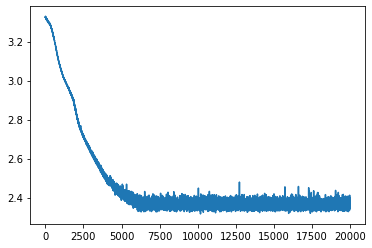

In [8]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

saving figure to file ./figures/scvelo_humanbonemarrow_pojection.png


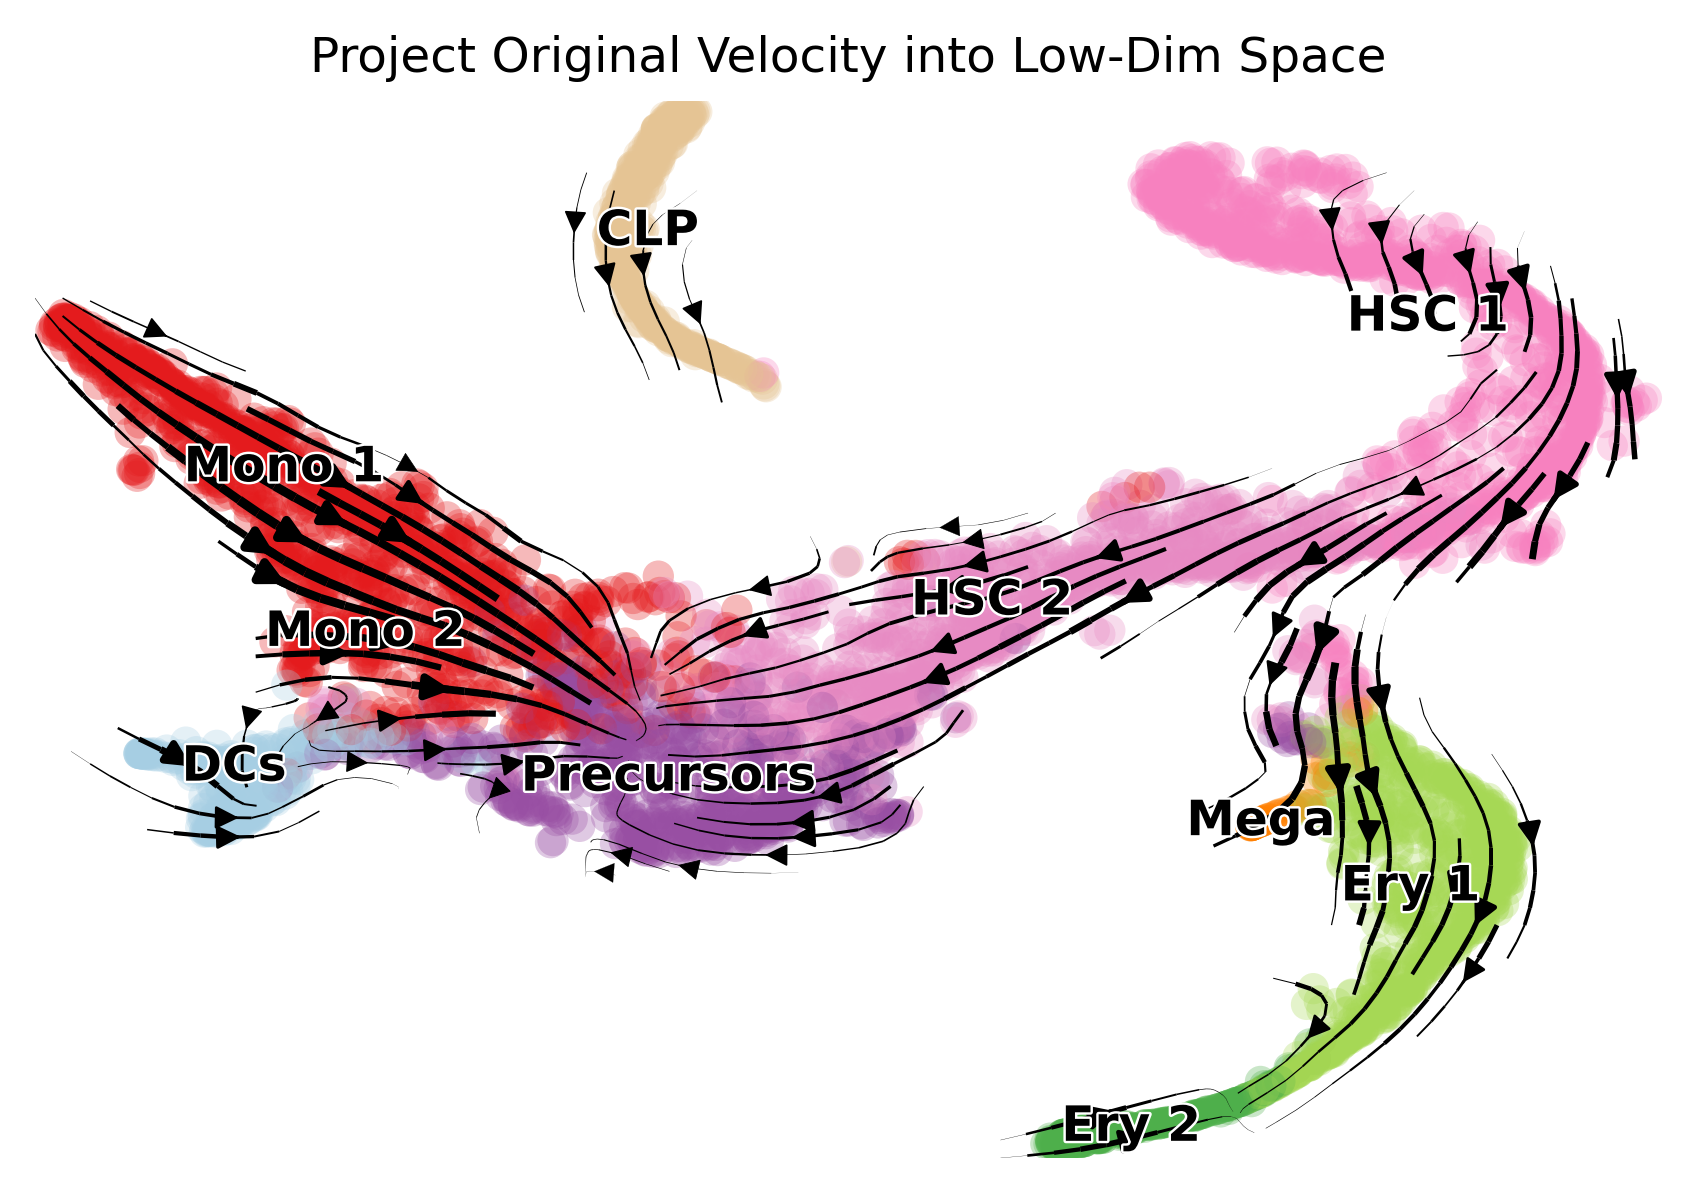

# Cross-Boundary Transition Score (A->B)
{('Ery_1', 'Ery_2'): 0.3195562, ('HSC_1', 'HSC_2'): 0.48677775, ('Mono_1', 'Mono_2'): 0.42715615}
Total Mean: 0.4111633598804474
# Cross-Boundary Velocity Coherence (A->B)
{('Ery_1', 'Ery_2'): 0.6902701, ('HSC_1', 'HSC_2'): 0.9444184, ('Mono_1', 'Mono_2'): 0.97994494}
Total Mean: 0.8715445399284363
# Cross-Boundary Direction Correctness (A->B)
{('Ery_1', 'Ery_2'): 0.33070219225638087, ('HSC_1', 'HSC_2'): 0.7026090897359513, ('Mono_1', 'Mono_2'): 0.6217754058617351}
Total Mean: 0.5516955626180223
# In-cluster Coherence
{'CLP': 0.9455529, 'DCs': 0.96006054, 'Ery_1': 0.86179894, 'Ery_2': 0.9055754, 'HSC_1': 0.9627469, 'HSC_2': 0.88523084, 'Mega': 0.85108095, 'Mono_1': 0.98037636, 'Mono_2': 0.9589225, 'Precursors': 0.84639466}
Total Mean: 0.9157739877700806
# In-cluster Confidence
{'CLP': 0.9475378973837025, 'DCs': 0.9505014106778815, 'Ery_1': 0.8291645673959644, 'Ery_2': 0.9000160707617706, 'HSC_1': 0.9495615078322089, 'HSC_2': 0.8583694428959824, 

In [11]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=args.use_offset_pred).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.ld_nb_g_src, n_nb_newadata=args.n_nb_newadata, X_emb_key=args.vis_key)
    scv.tl.velocity_graph(adata, vkey='new_velocity')
    scv.pl.velocity_embedding_stream(adata, 
                                    vkey="new_velocity", basis=args.vis_key, color=[args.vis_type_col],
                                    title="Project Original Velocity into Low-Dim Space", smooth=0.5,
                                    dpi=350,
                                    save='humanbonemarrow_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, args.vis_type_col, "new_velocity", x_emb=args.vis_key)
exp(adata, exp_metrics)

Abundance of ['spliced', 'unspliced']: [0.52 0.48]


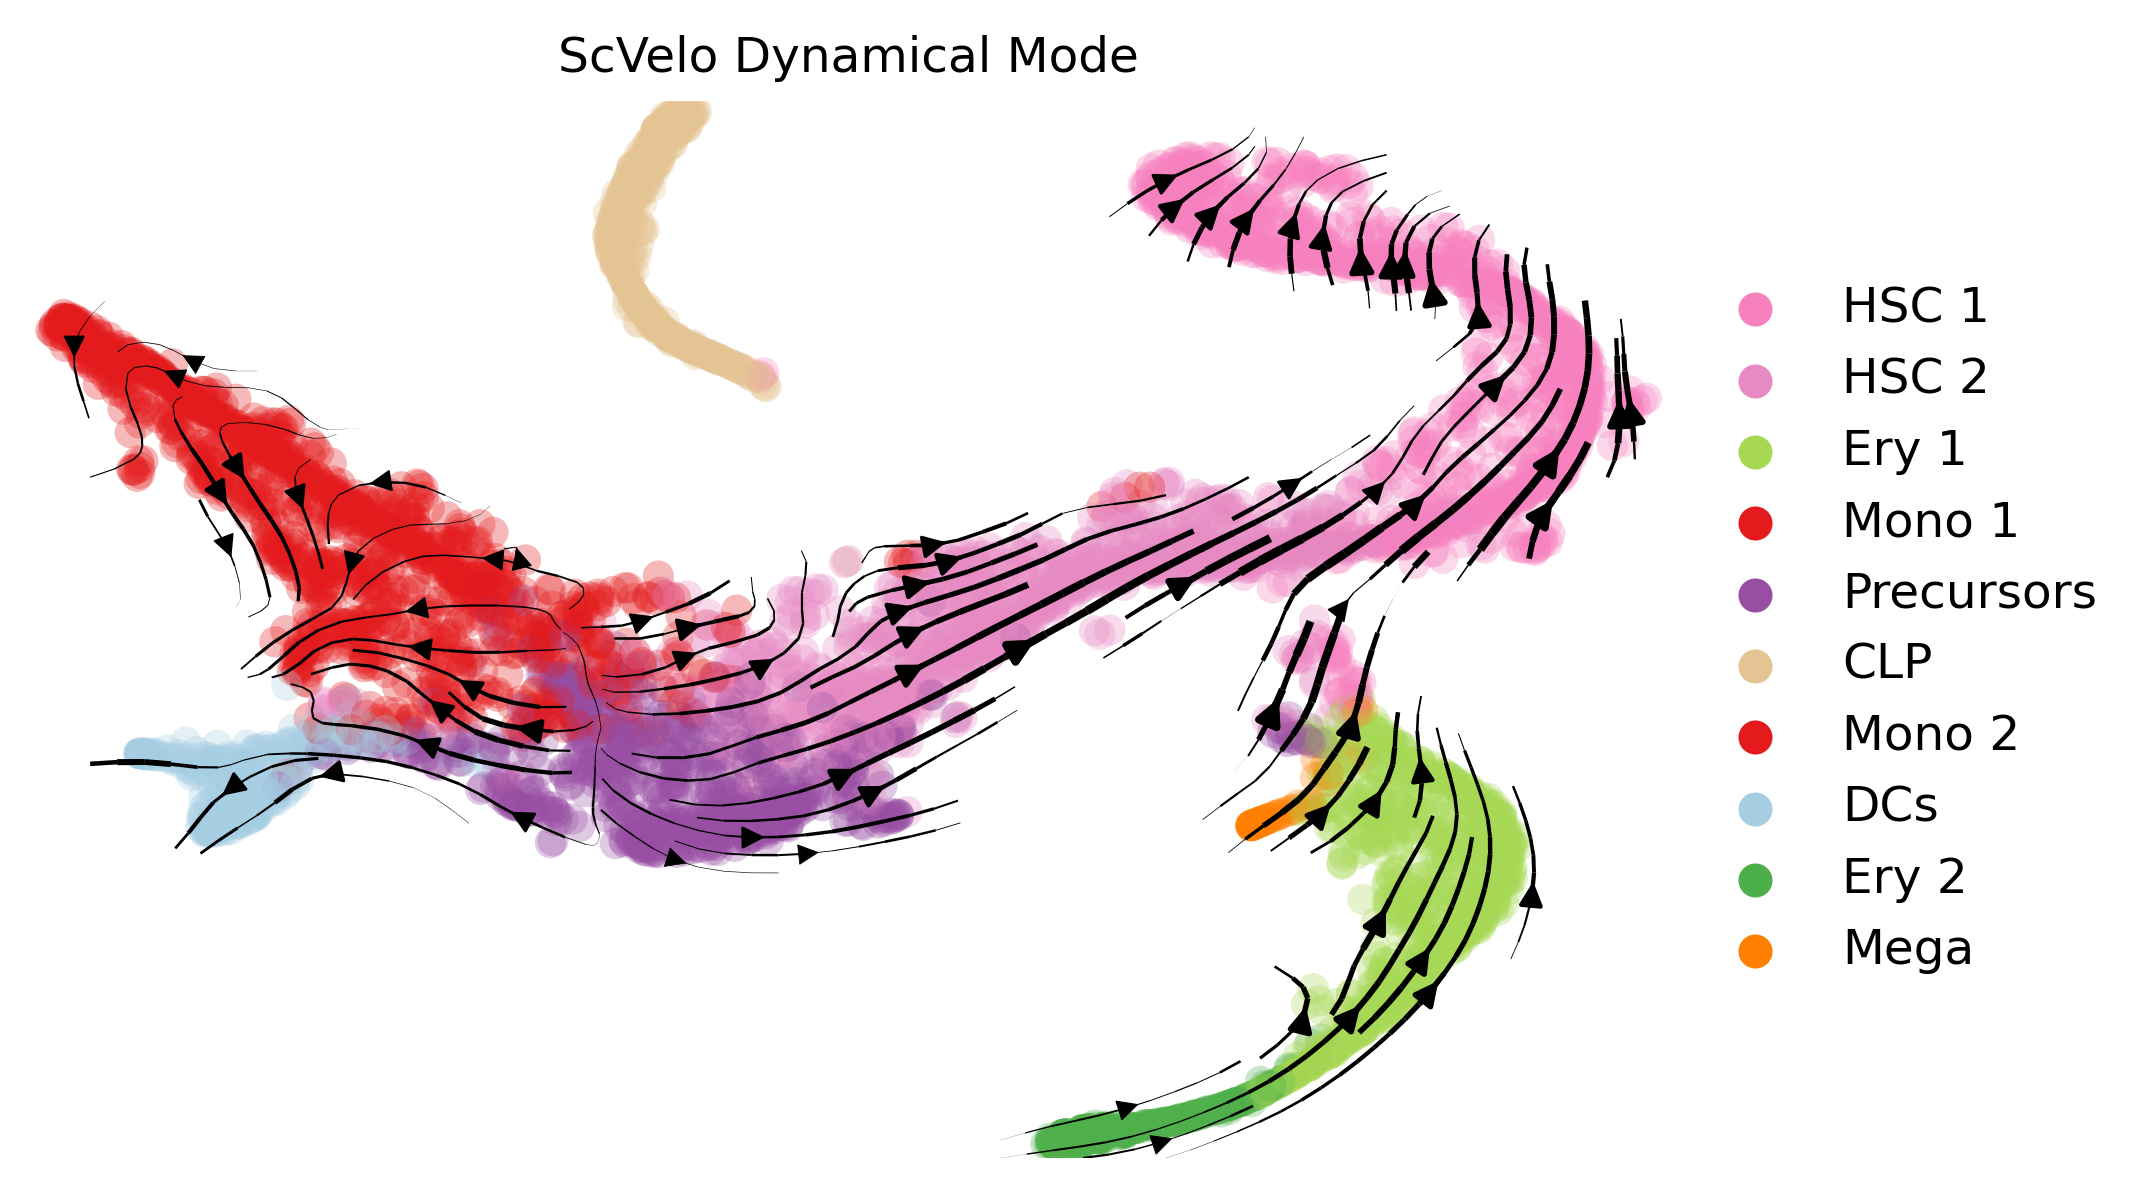

# Cross-Boundary Transition Score (A->B)
{('Ery_1', 'Ery_2'): 0.16312364, ('HSC_1', 'HSC_2'): 0.11940242, ('Mono_1', 'Mono_2'): 0.29825956}
Total Mean: 0.19359521567821503
# Cross-Boundary Velocity Coherence (A->B)
{('Ery_1', 'Ery_2'): 0.9685650576485176, ('HSC_1', 'HSC_2'): 0.9283358913031748, ('Mono_1', 'Mono_2'): 0.8207087785017703}
Total Mean: 0.9058699091511543
# Cross-Boundary Direction Correctness (A->B)
{('Ery_1', 'Ery_2'): -0.8804287271983982, ('HSC_1', 'HSC_2'): -0.7563976816325891, ('Mono_1', 'Mono_2'): 0.36578565727521994}
Total Mean: -0.4236802505185892
# In-cluster Coherence
{'CLP': 0.7823447656646586, 'DCs': 0.881145866305459, 'Ery_1': 0.9727743667894119, 'Ery_2': 0.9820206593639266, 'HSC_1': 0.9395151698445163, 'HSC_2': 0.94202098568107, 'Mega': 0.9806061609079643, 'Mono_1': 0.8728455823864374, 'Mono_2': 0.9059894494357751, 'Precursors': 0.8708609648112899}
Total Mean: 0.913012397119051
# In-cluster Confidence
{'CLP': 0.7630323106994038, 'DCs': 0.8736475938408083, 'Ery_

In [12]:
adata = scv.datasets.bonemarrow()
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, n_jobs=args.scv_n_jobs)
scv.tl.velocity(adata, vkey='dyn_velocity', mode="dynamical")

scv.tl.velocity_graph(adata, vkey='dyn_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                legend_loc="right margin", 
                                vkey="dyn_velocity", 
                                basis=args.vis_key, 
                                color=[args.vis_type_col],
                                dpi=350, 
                                title='ScVelo Dynamical Mode')
exp_metrics["dyn_mode"] = evaluate(adata[:, adata.var.dyn_velocity_genes], cluster_edges, args.vis_type_col, "dyn_velocity", x_emb=args.vis_key)

In [13]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)